In [458]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

In [459]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

In [460]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

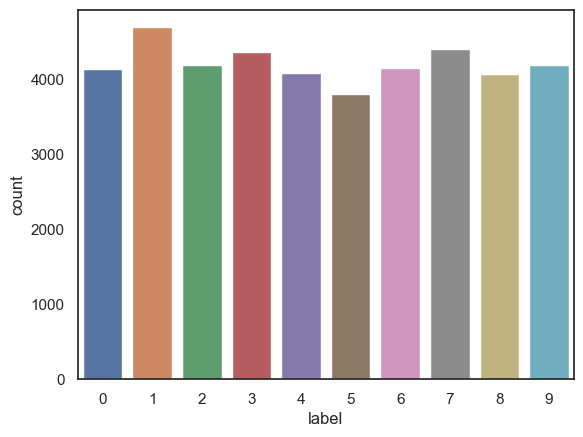

In [461]:
X_train = train.drop('label', axis=1)
y_train = train['label']

sns.countplot(train, x='label')

y_train.value_counts()

In [127]:
# free up some space
del train

## Check missing value

In [462]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [463]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

There is no missing values in the train and test dataset.

In [464]:
X_train.describe()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


## Normalization

Perform a grayscale normalization to reduce the effect of illumination's difference

- CNN converg faster on [0..1] data than on [0..255].

In [465]:
X_train = X_train / 255
test = test / 255

## Reshape

Keras requires extra dimension which correspond to color channels.

In [466]:
X_train = X_train.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

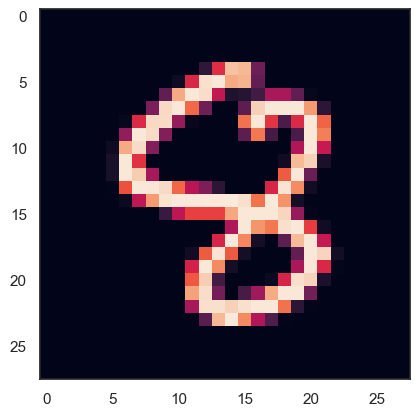

In [555]:
plt.imshow(X_train[1234])

## Label Encoding

In [468]:
y_train = to_categorical(y_train, num_classes = 10)

In [469]:
y_train[1]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

## Split training and validation set
Since we have 42000 training images of balanced labels, a random split of the train set doesn't cause some labels to be over represented in the validation set. 

In [470]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.1, random_state=2)

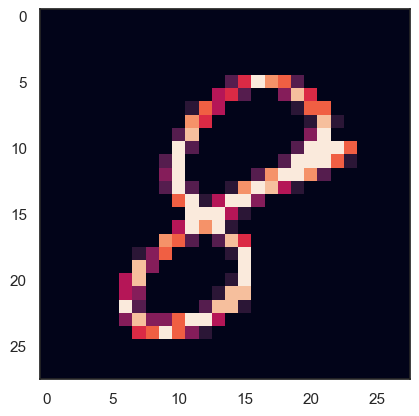

In [471]:
plt.imshow(X_train[0][:, :, 0])

The first is the convolutional (Conv2D) layer. It is like a set of learnable filters. I choosed to set 32 filters for the two firsts conv2D layers and 64 filters for the two last ones. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. ___Filters can be seen as a transformation of the image___. 

Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.

In [472]:
test.shape

(28000, 28, 28, 1)

In [473]:
X_train.shape

(37800, 28, 28, 1)

- tf.cast(x, dtype):  Converts a variable into a given data type
- buffer size: is used when we are dealing with enormous data sets. For example we can't suffle the whole dataset in one go because we can't possible fit it all in the memory


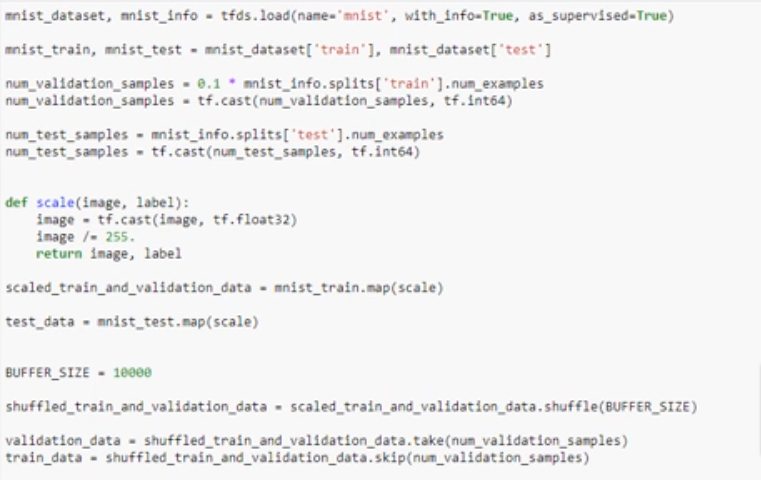

In [139]:
# import tensorflow as tf

# train_dataset = tf.data.Dataset.from_tensor_slices(X_train)

# BATCH_SIZE = 64
# BUFFER_SIZE = 100
# train_dataset = train_dataset.shuffle(buffer_size=BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)


# validation_dataset = tf.data.Dataset.from_tensor_slices(X_val)
# test_dataset = tf.data.Dataset.from_tensor_slices(test)

# validation_dataset = validation_dataset.batch(X_val.shape[0])
# test_dataset = test_dataset.batch(test.shape[0])

## Model

In [477]:
input_size = 784
output_size = 10
hidden_layer_size = 100

model = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(hidden_layer_size + 50, activation='relu'),
    Dense(hidden_layer_size, activation='relu'),
    Dense(hidden_layer_size, activation='relu'),
    Dense(output_size, activation='softmax')
])

### Choose the optimizer and the loss function

In [538]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

model.compile(optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=lr_schedule),  loss='categorical_crossentropy', metrics=['accuracy'])

### Training

In [539]:
NUM_EPOCHS = 5
BATCH_SIZE = 64

model.fit(X_train, y_train, epochs = NUM_EPOCHS, batch_size = BATCH_SIZE, validation_data = (X_val, y_val))

Epoch 1/5
591/591 [==============================] - 1s 774us/step - loss: 0.0018 - accuracy: 0.9999 - val_loss: 0.0934 - val_accuracy: 0.9786
Epoch 2/5
591/591 [==============================] - 0s 694us/step - loss: 0.0018 - accuracy: 0.9999 - val_loss: 0.0934 - val_accuracy: 0.9786
Epoch 3/5
591/591 [==============================] - 0s 674us/step - loss: 0.0018 - accuracy: 0.9999 - val_loss: 0.0935 - val_accuracy: 0.9786
Epoch 4/5
591/591 [==============================] - 1s 1ms/step - loss: 0.0018 - accuracy: 0.9999 - val_loss: 0.0935 - val_accuracy: 0.9786
Epoch 5/5
591/591 [==============================] - 0s 670us/step - loss: 0.0018 - accuracy: 0.9999 - val_loss: 0.0935 - val_accuracy: 0.9786


132/132 [==============================] - 0s 294us/step


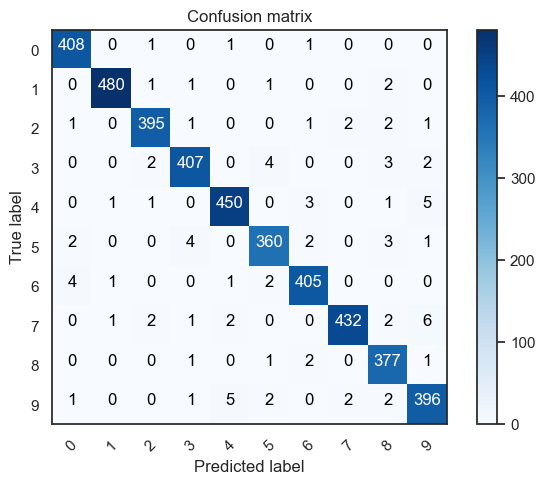

In [540]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [541]:
from PIL import Image

image_path = './digit6.png'
image = Image.open(image_path)

In [542]:
# convert it to grayscale
image = image.convert('L')

In [543]:
# crop the image to have the size of 28x28
cropped_image = image.resize((28, 28))

In [544]:
cropped_image = np.array(cropped_image)

In [545]:
cropped_image.max(axis=0)

array([ 28,  28,  28,  28,  28,  28,  28,  44, 234, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 174,  28,  28,  28,  28,
        28,  28], dtype=uint8)

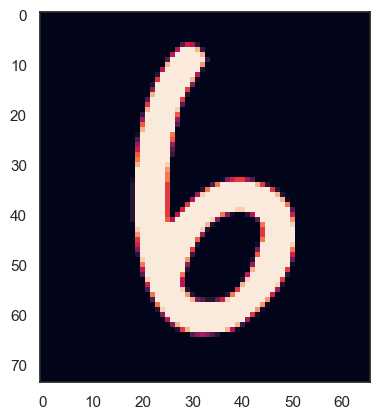

In [546]:
plt.imshow(image)

In [547]:
# normalize
cropped_image = cropped_image / 255.
cropped_image.max()

1.0

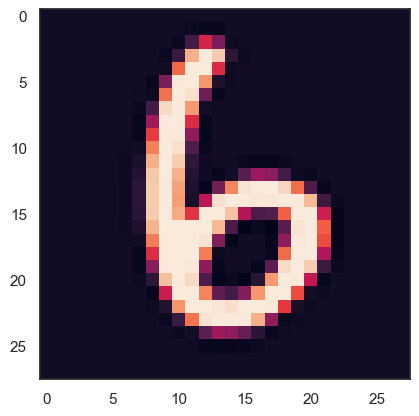

In [548]:
plt.imshow(cropped_image)

In [549]:
cropped_image = cropped_image.reshape(-1, 28, 28, 1)

In [550]:
cropped_image.shape

(1, 28, 28, 1)

In [551]:
y_pred = model.predict(cropped_image)

1/1 [==============================] - 0s 17ms/step


In [552]:
y_pred.argmax()

6